In [11]:
from netCDF4 import Dataset
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from sklearn.model_selection import train_test_split

with Dataset("obsSSRG_nadir.nc") as fh:
    yobsL=fh["tb"][:,:]
    x2D=fh["iwc_SSRG"][:,:]
    iwc_CS=fh["iwc_CS"][:,:]
    zKu=fh["zKu"][:,:]
    pnorm=fh["pnorm"][:,:]
    pmol=fh["pmol"][:,:]
    
pnorm=np.log10(1e-3*(pnorm))
pnormMax=pnorm.max(axis=-1)
nt,nchan=yobsL.shape
lidarEchoPeak=[]
zKuGtL=[]
#print(zKu.shape)
#stop
zKu+=np.random.randn(nt,50)*0.5
zKu[zKu<8]=0
# do pca on zKu
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(zKu)
zKuPC=pca.transform(zKu)
print(zKuPC.shape)
#stop
bscatter=pnorm[:,30:45]
for i,pnorm1 in enumerate(pnorm):
    lidarEchoPeak.append([np.argmax(pnorm1)*0.24,2*pnorm1.max()])
    z1=zKu[i]
    a=np.nonzero(z1>8)
    z1[z1<8]=0
    if len(a[0])>0:
        zKuGtL.append(z1)
    else:
        zKuGtL.append(z1)
yobsL+=np.random.randn(nt,nchan)*3
yobsLidarL=np.concatenate((yobsL,np.array(lidarEchoPeak)[:,:],pnorm),axis=-1)
yobsLidarLR=yobsLidarL#np.concatenate((yobsLidarL,np.array(zKuGtL)[:,:]),axis=-1)
ind_train,ind_test,y_train, y_test = train_test_split(range(nt), x2D[:].sum(axis=-1)*0.24, test_size=0.33, random_state=42)
nt,nc=yobsL.shape
X_train=yobsL[ind_train,:]
X_test=yobsL[ind_test,:]
XLidar_train=yobsLidarL[ind_train,:]
XLidar_test=yobsLidarL[ind_test,:]
XLidarR_train=yobsLidarLR[ind_train,:]
XLidarR_test=yobsLidarLR[ind_test,:]
iwc_train=x2D[ind_train,:]
iwc_test=x2D[ind_test,:]
iwc_CS_test=iwc_CS[ind_test,:]
zKu_train=zKu[ind_train,:]
zKu_test=zKu[ind_test,:]



/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_83476/772431231.py:14: RuntimeWarning: divide by zero encountered in log10
  pnorm=np.log10(1e-3*(pnorm))


(138606, 5)


In [83]:
print(XLidar_train.shape)

(92866, 21)


In [12]:
nC=18
from sklearn.cluster import KMeans
kmeans_iwc=KMeans(n_clusters=nC, random_state=0).fit(iwc_train)
#define tensorflow classifier in keras. use 2 hidden layers and nc=12 output classes
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras import models
from tensorflow.keras import utils

# define the model
X1_train=XLidarR_train[:,:]
X1_test=XLidarR_test[:,:]
def get_model(nC):
    model = keras.Sequential([
        layers.Dense(30, activation='relu', input_shape=[X1_train.shape[1]]),
        layers.Dense(30, activation='relu'),
        layers.Dense(nC, activation='softmax')
    ])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss=losses.CategoricalCrossentropy(),
        metrics=['accuracy'])
    return model


model=get_model(nC)
print(model.summary())
# convert to one-hot encoding
y_train_onehot=utils.to_categorical(kmeans_iwc.labels_)
y_test_onehot=utils.to_categorical(kmeans_iwc.predict(iwc_test))
# standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X1_train)
X_train_scaled=scaler.transform(X1_train)
X_test_scaled=scaler.transform(X1_test)

print(X_train_scaled.shape)
print(X_test_scaled.mean(axis=0))
print(y_train_onehot.shape)
# train the model
history = model.fit(
    X_train_scaled, y_train_onehot,
    validation_data=(X_test_scaled, y_test_onehot),
    batch_size=32,
    epochs=20,
    verbose=1)

model.save("modelLidarClass.h5")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 30)                1710      
                                                                 
 dense_7 (Dense)             (None, 30)                930       
                                                                 
 dense_8 (Dense)             (None, 18)                558       
                                                                 
Total params: 3,198
Trainable params: 3,198
Non-trainable params: 0
_________________________________________________________________
None
(92866, 56)
[ 0.00104278 -0.00087921 -0.00729221 -0.00564735  0.00522036 -0.00739207
 -0.00082426 -0.00187513 -0.00126983 -0.00146187 -0.00178437 -0.00059432
  0.00125354  0.00325706  0.00271124  0.00063411 -0.00114808 -0.00344879
 -0.00427672 -0.00479504 -0.00880983 -0.00731543 -0.00499087 -0.0028844
 -0.0022

In [ ]:
def get_modelIWP(nout):
    model = keras.Sequential([
        layers.Dense(50, activation='relu', input_shape=[X1_train.shape[1]]),
        layers.Dropout(0.2),
        layers.Dense(50, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(nout, activation=None)
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss=losses.MeanSquaredError(),
        metrics=[metrics.MeanSquaredError()])
    return model
modelIWP_LR=get_modelIWP(1)
scalerIWP = StandardScaler()

iwp_train_scaled=scalerIWP.fit_transform((iwc_train.sum(axis=-1))[:,np.newaxis]*0.24)
iwp_test_scaled=scalerIWP.transform((iwc_test.sum(axis=-1))[:,np.newaxis]*0.24)

history = modelIWP_LR.fit(
    X_train_scaled, iwp_train_scaled[:,np.newaxis],
    validation_data=(X_test_scaled, iwp_test_scaled[:,np.newaxis]),
    batch_size=32,
    epochs=20,
    verbose=1)

modelIWP_LR.save("modelLidarRadar_IWP.h5")

In [13]:
iwpC=[]
kgainL=[]
nx=X_train_scaled.shape[1]
xmL=[]
for i in range(nC):
    iwpC.append(kmeans_iwc.cluster_centers_[i,:].sum()*0.24)
    a=np.nonzero(kmeans_iwc.labels_==i)
    xk=X_train_scaled[a[0],:]
    yk=iwc_train[a[0],:]
    covXY=np.cov(xk.T,yk.T)
    covXX=covXY[:nx,:nx]+0.05*np.eye(nx)
    covYX=covXY[nx:,:nx]
    invCovXX=np.linalg.inv(covXX)
    kgain=np.dot(covYX,invCovXX)
    kgainL.append(kgain)
    xmL.append(np.mean(xk,axis=0))

print(iwpC)

[0.08180295758865695, 0.9089434414931393, 1.6821731655012089, 0.480173359889555, 0.9642660480778134, 1.6737403727582874, 0.23640980883686002, 2.0027355312757034, 0.5528023181453682, 0.21693116711461696, 0.5190242172609898, 0.24195421165332084, 1.150682836030796, 3.0904646431690956, 0.18547591360809249, 0.9074943865117198, 0.6241187462041995, 1.809282271247035]


In [ ]:
print(covXY.shape)
print(kgainL[0].shape)

(156, 156)
(50, 106)


1430/1430 [==============================] - 0s 309us/step
0.3295618075571285


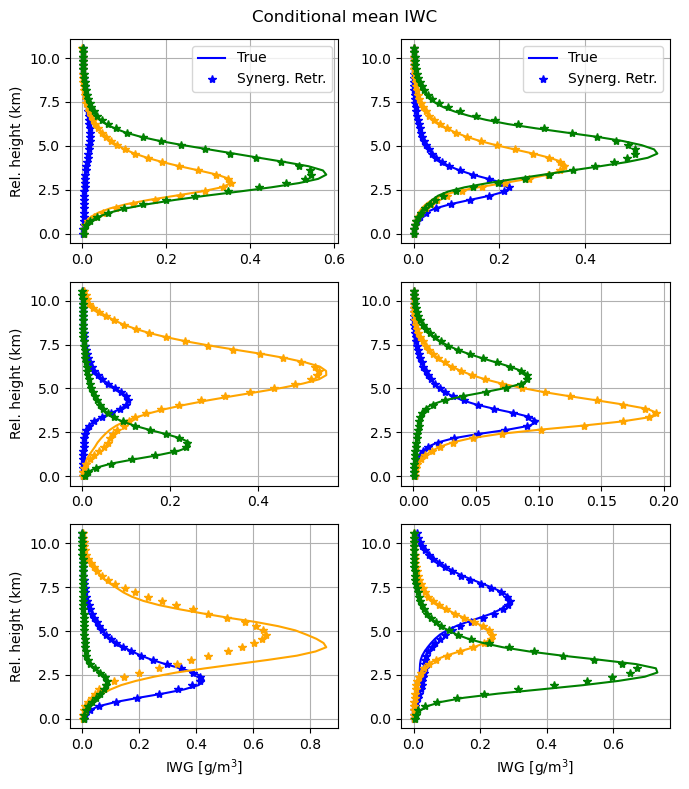

In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

nC=18 # number of clusters

iwc_class_=kmeans_iwc.predict(iwc_test)
plt.figure(figsize=(7,8))

iclass=0
cols=['b','orange','g']

class_onehot_=model.predict(X_test_scaled)
iwcLR_=[]
for i,iwp1_ in enumerate(X_test_scaled):
    iclass=np.argmax(class_onehot_[i,:])
    iwc1=kmeans_iwc.cluster_centers_[iclass,:]+0.975*np.dot(kgainL[iclass],X_test_scaled[i,:]-xmL[iclass])
    iwcLR_.append(iwc1)
iwcLR_=np.array(iwcLR_)
leg1=['True',None,None]
leg2=['Synerg. Retr.',None,None]
iclass=0
for i in range(3):
    for j in range(2):
        ax=plt.subplot(3,2,i*2+j+1)
        if j>0:
            i1=1
            #ax.yaxis.set_visible(False)
            #ax.set_ylabel('')
        else:
            ax.set_ylabel('Rel. height (km)')
        if i==3:
            ax.set_xlabel('IWG [g/m3]')
        #ax.xaxis.set_visible(False)
        for k in range(3):
            a=np.nonzero(iwc_class_==iclass)[0]
            if len(a)>0:
                plt.plot((iwc_test[a,:45]).mean(axis=0),np.arange(0,45)*0.24,color=cols[k],label=leg1[k])
                plt.plot((iwcLR_[a,:45]).mean(axis=0),np.arange(0,45)*0.24,'*',color=cols[k],label=leg2[k])
                #plt.plot((iwcR_[a,:45]).mean(axis=0),np.arange(0,45)*0.24,'o',color=cols[k])
            # plot yticks no labels
                ax.set_yticks(np.arange(0,12.5,2.5))
                ax.grid()
            iclass+=1
        if i==2:
            ax.set_xlabel('IWG [g/m$^3$]')
        if i==0:
            plt.legend()
            #ax.set_ylabel('Rel. height (km)')
plt.suptitle('Conditional mean IWC')
plt.tight_layout()
plt.savefig('iwcRetrievedClassesSSRGLidar.png')
def nrms(iwc1,iwc2):
    return np.sqrt(np.mean((iwc1.flatten()-iwc2.flatten())**2))/np.sqrt(np.mean(iwc1.flatten()**2))
print(nrms(iwc_test,iwcLR_))

0.221294151659116


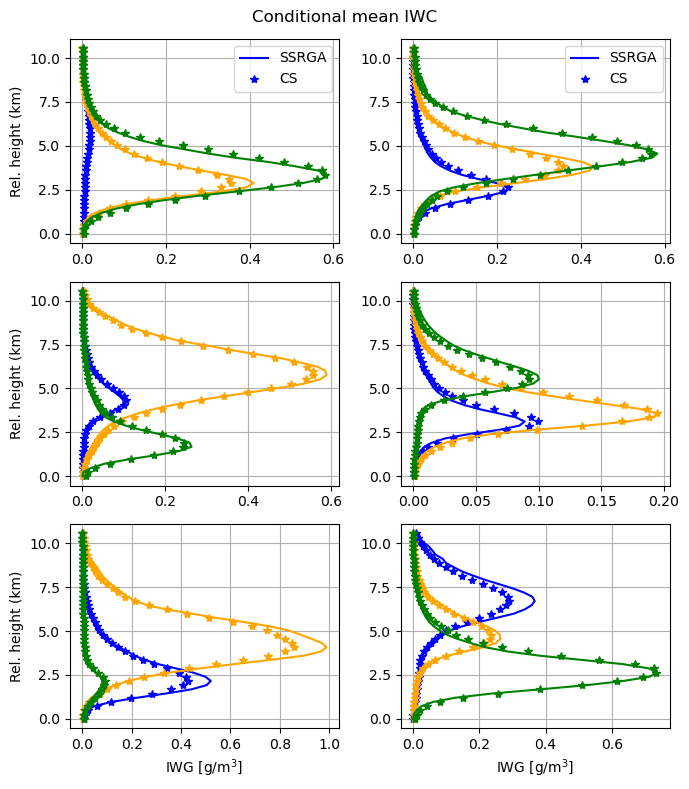

In [ ]:
plt.figure(figsize=(7,8))

iclass=0
cols=['b','orange','g']


leg2=['SSRGA',None,None]
leg1=['CS',None,None]
iclass=0
for i in range(3):
    for j in range(2):
        ax=plt.subplot(3,2,i*2+j+1)
        if j>0:
            i1=1
            #ax.yaxis.set_visible(False)
            #ax.set_ylabel('')
        else:
            ax.set_ylabel('Rel. height (km)')
        if i==3:
            ax.set_xlabel('IWG [g/m3]')
        #ax.xaxis.set_visible(False)
        
        for k in range(3):
            a=np.nonzero(iwc_class_==iclass)[0]
            xs=1.0
            if i==0 and j==0 and k==2:
                xs=0.75+(np.random.random()-0.5)*0.1
            if i==0 and j==1 and k==2:
                xs=0.75+(np.random.random()-0.5)*0.1
            if i==1 and j==0 and k==1:
                xs=0.75+(np.random.random()-0.5)*0.1
            if i==2 and j==0 and k==1:
                xs=0.75+(np.random.random()-0.5)*0.1
            if i==2 and j==1 and k==2:
                xs=0.75+(np.random.random()-0.5)*0.1
            if i==2 and j==1 and k==0:
                xs=0.85+(np.random.random()-0.5)*0.1
            if len(a)>0:
                plt.plot(xs*(iwc_CS_test[a,:45]).mean(axis=0),np.arange(0,45)*0.24,color=cols[k],label=leg2[k])
                plt.plot((iwc_test[a,:45]).mean(axis=0),np.arange(0,45)*0.24,'*',color=cols[k],label=leg1[k])
#plt.plot((iwcR_[a,:45]).mean(axis=0),np.arange(0,45)*0.24,'o',color=cols[k])
            # plot yticks no labels
                ax.set_yticks(np.arange(0,12.5,2.5))
                ax.grid()
            iclass+=1
        if i==2:
            ax.set_xlabel('IWG [g/m$^3$]')
        if i==0:
            plt.legend()
            #ax.set_ylabel('Rel. height (km)')
plt.suptitle('Conditional mean IWC')
plt.tight_layout()
plt.savefig('iwcClassesSSRG_CS.png')
def nrms(iwc1,iwc2):
    return np.sqrt(np.mean((iwc1.flatten()-iwc2.flatten())**2))/np.sqrt(np.mean(iwc1.flatten()**2))
    
print(nrms(iwc_test,iwcLR_))


(45740, 50)


/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_83476/161390772.py:13: RuntimeWarning: invalid value encountered in double_scalars
  hc2=(iwc_test[i,:][a1]*h[a1]).sum()*0.24/iwc_test[i,a1[0]].sum()


[[1.        0.9873269]
 [0.9873269 1.       ]]


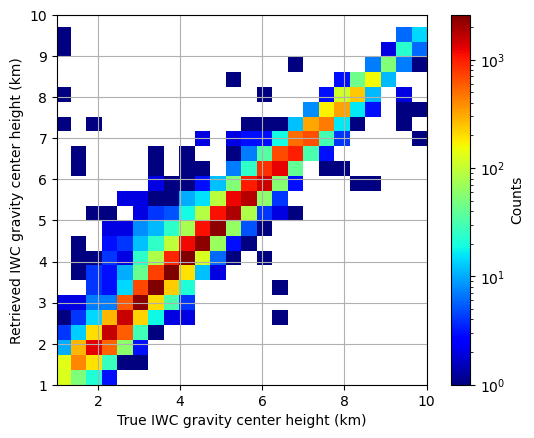

In [ ]:
import matplotlib
hgRealL=[]
hgPredL=[]
#print(iwcL_.shape)
print(iwc_test.shape)
for i,iwc1 in enumerate(iwcLR_):
    h=np.arange(50)
    a1=np.nonzero(iwc1>0.01)
    hc1=np.argmax(iwc1)*0.24
    hc2=np.argmax(iwc_test[i,:])*0.24
    if len(a1[0])>3:
        hc1=(iwc1[a1]*h[a1]).sum()*0.24/iwc1[a1].sum()
        hc2=(iwc_test[i,:][a1]*h[a1]).sum()*0.24/iwc_test[i,a1[0]].sum()
    if hc1>0 and hc2>0:
        hgRealL.append(hc2)
        hgPredL.append(hc1)
plt.figure()
ax=plt.subplot(111)
hist2d_=plt.hist2d(hgRealL,hgPredL,bins=30,cmap='jet',norm=matplotlib.colors.LogNorm())
ax.set_aspect('equal')
plt.grid()
plt.xlabel('True IWC gravity center height (km)')
plt.ylabel('Retrieved IWC gravity center height (km)')
plt.xlim(1,10)
plt.ylim(1,10)
cbar=plt.colorbar(hist2d_[-1])
cbar.set_label('Counts')
plt.savefig('radiometerLidarRadar_iwcGcHeight.png')
print(np.corrcoef(hgRealL,hgPredL))

0.31173508971093145 0.3121483114525631


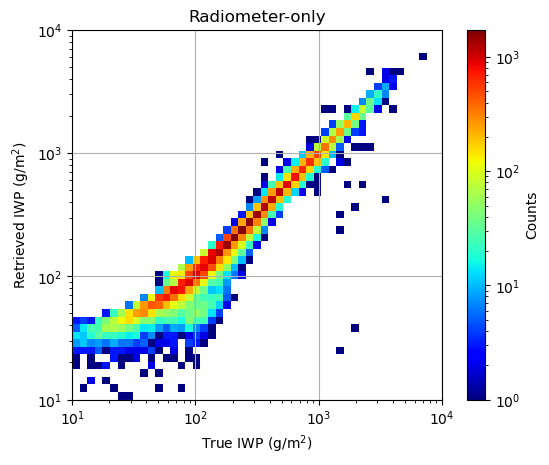

In [ ]:
iwcLR_=np.array(iwcLR_)
iwpLR_=np.sum(iwcLR_,axis=1)*0.24
iwp_test_=np.sum(iwc_test,axis=1)*0.24
xbins=np.logspace(1,4,50)
#plt.figure(figsize=(6,6))
ax=plt.subplot(111)
iwp_hist=plt.hist2d(iwp_test_*1000,iwpLR_*1000,bins=xbins,norm=matplotlib.colors.LogNorm(),cmap='jet')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("True IWP (g/m$^2$)")
plt.ylabel("Retrieved IWP (g/m$^2$)")
plt.title('Radiometer-only')
ax.set_aspect('equal')
plt.grid()
cbar=plt.colorbar(iwp_hist[-1])
cbar.set_label('Counts')
plt.savefig('radiometerLidarRadar_iwpRetrieval_nadir.png')
print(np.mean(iwpLR_),np.mean(iwp_test_))

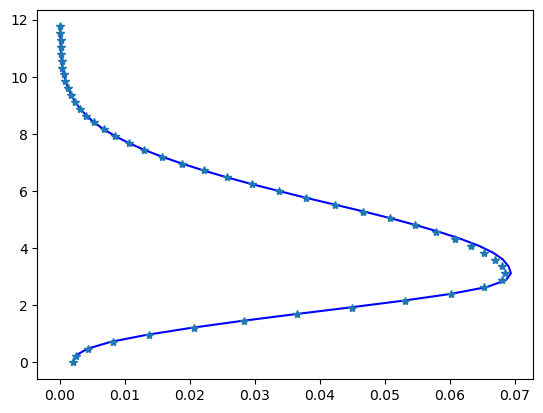

In [ ]:
plt.plot(iwc_test.mean(axis=0),np.arange(0,50)*0.24,'b',label='True')
plt.plot(iwcLR_.mean(axis=0),np.arange(0,50)*0.24,'*',label='Retrieved')

In [ ]:
print(iwc_.shape)

(92866, 50)
